In [1]:
import pandas as pd
import torch

In [2]:
df = pd.read_csv('voice.csv')
df

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


In [3]:
x = df.values[:, :-1]
x = torch.tensor(x.astype('float32'))
y = df.values[:, -1]
print('y', y)
y[y == 'male'] = 0
y[y == 'female'] = 1
print('y', y)
y = torch.tensor(y.astype('float32'))

y ['male' 'male' 'male' ... 'female' 'female' 'female']
y [0 0 0 ... 1 1 1]


In [4]:
from torch.utils.data import random_split, DataLoader, TensorDataset 

In [5]:
dataset = TensorDataset(x, y)
train_size = round(len(dataset) * 0.7)
test_size = len(dataset) - train_size
dataset_train, dataset_test = random_split(dataset, [train_size, test_size])

In [6]:
print('train', len(dataset_train))
print('test', len(dataset_test))

train 2218
test 950


In [7]:
batch_size = 16
train_data = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [8]:
from torch import nn

class VoiceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(20, 5),
            nn.Linear(5, 1),
        )
        self.sigmoid = nn.Sigmoid()
#         self.fc = nn.Sequential(
#             nn.Linear(20, 10),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(10, 3),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(3, 1),
#         )
    
    def forward(self, x):
        out = self.fc(x)
        return self.sigmoid(out)

In [9]:
device = torch.device('cuda:2')
model = VoiceModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [10]:
# test model
test_x = torch.rand(16, 20).to(device)
model(test_x).shape

torch.Size([16, 1])

In [11]:
from tqdm import tqdm
def train(model, data, epoch, criterion, optimizer, device, is_tqdm=False):
    model.train()
    loss_list = []
    acc_count = 0

    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, label) in loader:
        batch = batch.to(device)
        label = label.to(device).float()

        optimizer.zero_grad()
        score = model(batch).squeeze() # predict the label
        loss = criterion(score, label) # calculate error
        loss_list.append(loss.item())
        
        pred = score.round()
        acc_count += pred.eq(label).sum().item()
        
        loss.backward()  # back-propagation
        optimizer.step() # gradient descent

    acc = acc_count / (len(data) * data.batch_size) * 100
    return sum(loss_list) / len(loss_list), acc

def test(model, data, criterion, device, is_tqdm=False):
    model.eval()
    loss_list = []

    acc_count = 0
    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, label) in loader:
        batch = batch.to(device)
        label = label.to(device).float()

        score = model(batch).squeeze()
        loss = criterion(score, label)
        loss_list.append(loss.item())

        pred = score.round()
        acc_count += pred.eq(label).sum().item()

    acc = acc_count / (len(data) * data.batch_size) * 100
    return sum(loss_list) / len(loss_list), acc

In [12]:
from torch.optim.lr_scheduler import StepLR

max_epoch = 60
step_size = 30
log_interval = 5

scheduler = StepLR(optimizer, step_size=step_size, gamma=0.3)

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

for epoch in range(1, max_epoch + 1):
    if epoch % log_interval == 0:
        tqdm.write('==========Train Epoch {}=========='.format(epoch))
    train_loss, train_acc = train(model, train_data, epoch, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_data, criterion, device)
    scheduler.step()
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    if epoch % log_interval == 0:
        print('Train loss', round(train_loss, 4), 'Train acc', round(train_acc, 2))
        print('Test loss', round(test_loss, 4), 'Test acc', round(test_acc, 2))

==========Train Epoch 5==========
Train loss 0.743 Train acc 71.85
Test loss 0.6629 Test acc 78.02
==========Train Epoch 10==========
Train loss 0.5663 Train acc 80.53
Test loss 0.5886 Test acc 80.73
==========Train Epoch 15==========
Train loss 0.5264 Train acc 85.25
Test loss 0.4868 Test acc 88.75
==========Train Epoch 20==========
Train loss 0.5468 Train acc 87.14
Test loss 0.3597 Test acc 85.31
==========Train Epoch 25==========
Train loss 1.3476 Train acc 88.22
Test loss 0.5742 Test acc 90.31
==========Train Epoch 30==========
Train loss 1.4045 Train acc 88.26
Test loss 1.1298 Test acc 85.52
==========Train Epoch 35==========
Train loss 0.6096 Train acc 92.13
Test loss 0.2002 Test acc 92.71
==========Train Epoch 40==========
Train loss 0.4313 Train acc 93.08
Test loss 0.2929 Test acc 93.75
==========Train Epoch 45==========
Train loss 0.3955 Train acc 93.35
Test loss 0.2431 Test acc 93.75
==========Train Epoch 50==========
Train loss 0.2924 Train acc 94.51
Test loss 0.2025 Test ac

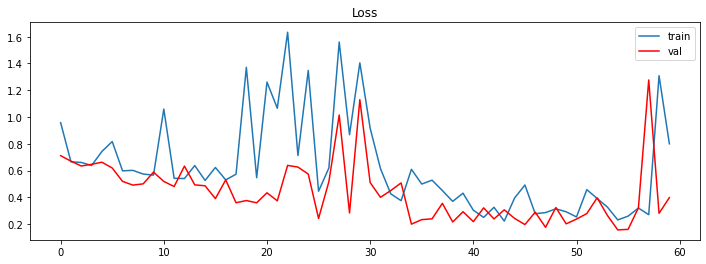

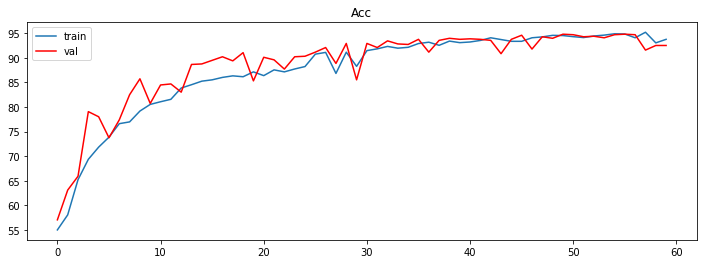

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

- AdamW 20, 5, 1  
Train loss 0.5460493305175425 Train acc 59.21762589928058  
Test loss 0.5605240558584531 Test acc 58.229166666666664